#Install lib

In [ ]:
%pip install cdsapi

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 49.3 MB/s eta 0:00:00


In [ ]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.1 MB/s eta 0:00:00


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import zipfile
import os
import cdsapi
from scipy.stats import linregress
import dask
import warnings
warnings.filterwarnings("ignore")

#Temperatur

In [ ]:
# Replace with your actual CDS API URL and Key
cds_url = "https://cds.climate.copernicus.eu/api"
cds_key = "1623753c-12aa-4b7c-93c3-c92ba585c4aa"

# Create the configuration file content
config_content = f"url: {cds_url}\nkey: {cds_key}"

# Define the path to the configuration file
config_file_path = os.path.expanduser("~/.cdsapirc")

# Write the configuration content to the file
with open(config_file_path, "w") as f:
    f.write(config_content)

print(f"CDS API configuration file created at: {config_file_path}")

CDS API configuration file created at: /root/.cdsapirc


In [ ]:
dataset = "insitu-gridded-observations-global-and-regional"
request = {
    "origin": "cru",
    "region": "global",
    "variable": ["temperature"],
    "statistic": ["mean"],
    "time_aggregation": "monthly",
    "horizontal_aggregation": ["1_x_1"],
    "year": [
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019"
    ],
    "version": ["v4_03"]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-10-23 01:51:13,431 INFO [2025-01-29T00:00:00] This dataset is no longer supported by the data providers. Data and documentation are provided as is. Users are encouraged to use our [Forum](https://forum.ecmwf.int/) to raise any item of discussion with respect to this dataset.
INFO:ecmwf.datastores.legacy_client:[2025-01-29T00:00:00] This dataset is no longer supported by the data providers. Data and documentation are provided as is. Users are encouraged to use our [Forum](https://forum.ecmwf.int/) to raise any item of discussion with respect to this dataset.
2025-10-23 01:51:13,433 INFO Request ID is 9d0c1e28-c47b-4ee3-9fea-63a5584d315e
INFO:ecmwf.datastores.legacy_client:Request ID is 9d0c1e28-c47b-4ee3-9fea-63a5584d315e
2025-10-23 01:51:13,583 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-23 01:51:27,524 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated 

58f7da8fea65ba1b7e6366a7a960ed92.zip:   0%|          | 0.00/60.2M [00:00<?, ?B/s]

'58f7da8fea65ba1b7e6366a7a960ed92.zip'

<xarray.Dataset> Size: 62MB
Dimensions:  (time: 240, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2000-01-01 2000-02-01 ... 2019-12-01
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    tas      (time, lat, lon) float32 62MB dask.array<chunksize=(1, 180, 360), meta=np.ndarray>
Attributes: (12/23)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    source:                     Run ID = 2004151855. Data generated from:tmp....
    institution:                KNMI Climate Explorer and Data held at Britis...
    Conventions:                CF-1.0
    title:                      CRU TS4.04 Mean Temperature  averaged over  2...
    cdi:                        Climate Data Interface version 1.9.8 (https:/...
    ...                         ...
    geospatial_lon_resolution:  1.0
    climexp_url:             

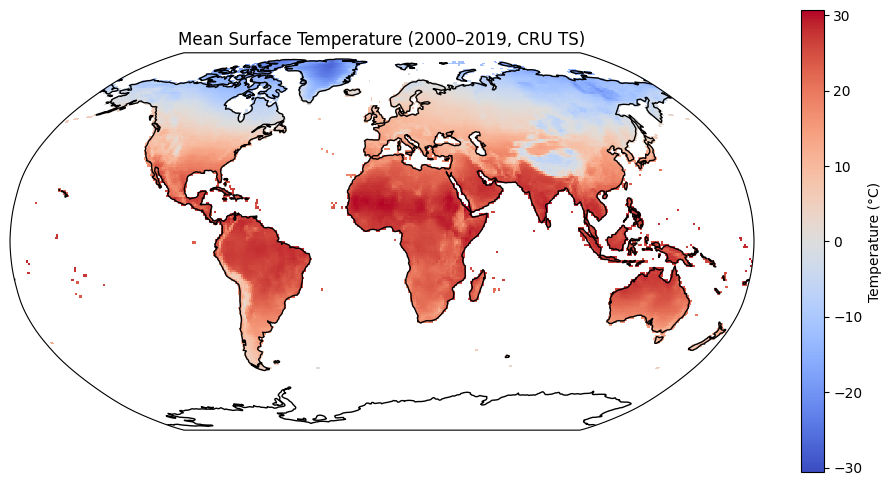

In [ ]:

#  Buka dan gabungkan semua file .nc ---
nc_files = sorted([os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith(".nc")])
data = xr.open_mfdataset(nc_files, combine='by_coords')

# Cek isi variabel ---
print(data)

# Asumsi variabel suhu: 'tas' (Temperature)
da = data['tas']

# Pastikan dalam °C
if da.max() > 200:  # berarti masih dalam Kelvin
    da = da - 273.15

#  Seleksi periode 2000–2019 ---
da = da.sel(time=slice("2000-01-01", "2019-12-31"))

# Hitung rata-rata global berbobot luas grid (cos(lat)) ---
weights = np.cos(np.deg2rad(da['lat']))
da_weighted = da.weighted(weights)
global_mean = da_weighted.mean(dim=("lat", "lon"))

# Plot spasial rata-rata jangka panjang ---
mean_spatial = da.mean(dim="time")

plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
mean_spatial.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="coolwarm",
    cbar_kwargs={'label': 'Temperature (°C)'}
)
ax.coastlines()
ax.set_title("Mean Surface Temperature (2000–2019, CRU TS)")
plt.show()

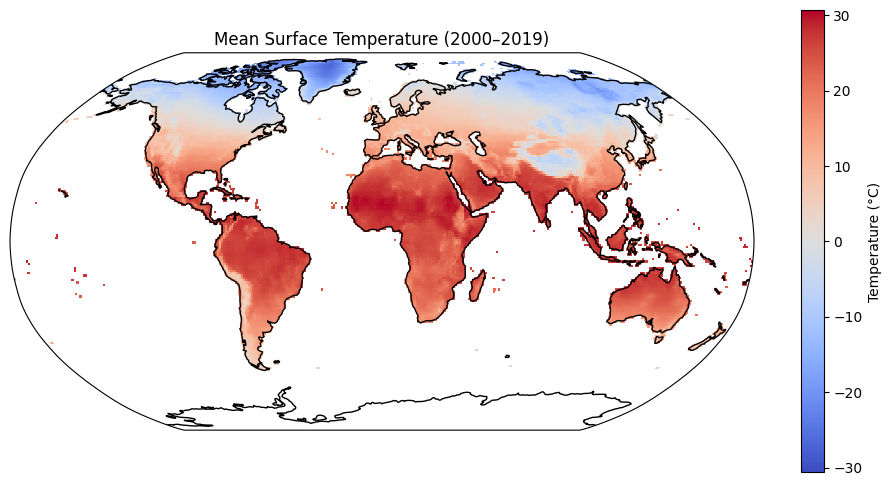

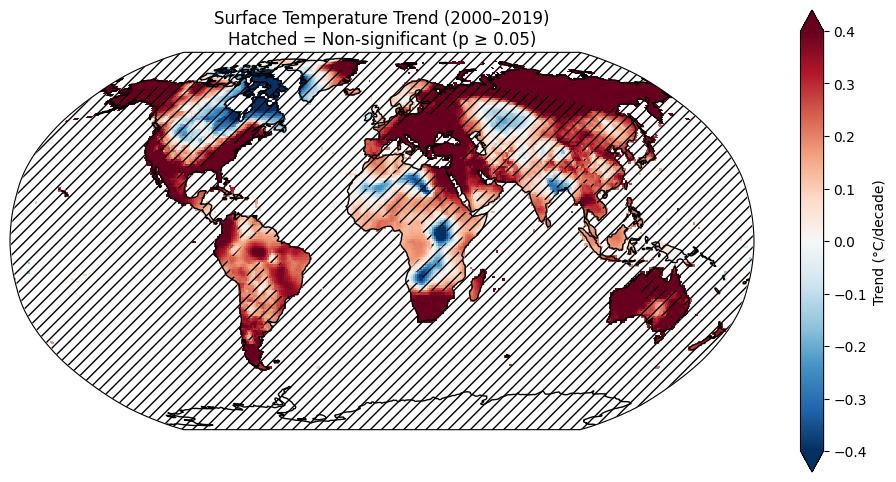

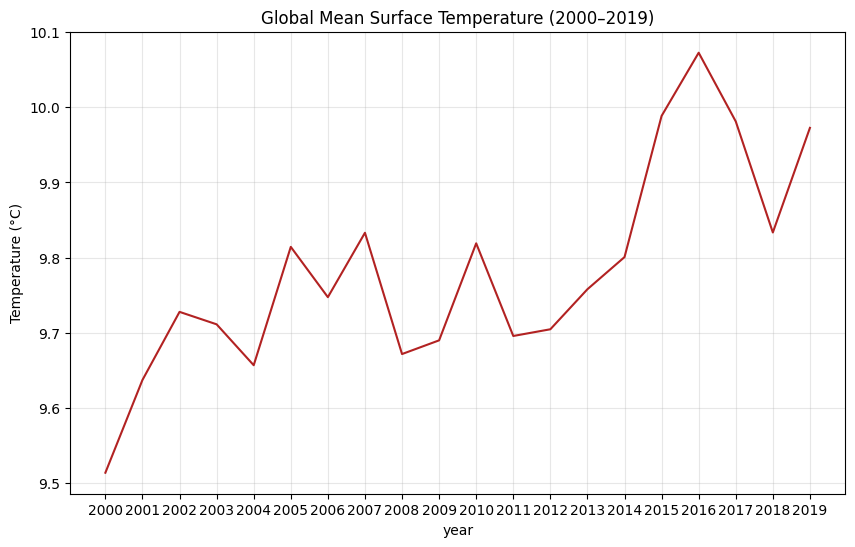

In [ ]:
nc_files = sorted([os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith(".nc")])
data = xr.open_mfdataset(nc_files, combine='by_coords', chunks={'time':12})

# --- Pilih variabel suhu ---
da = data['tas']
if da.max() > 200:
    da = da - 273.15  # Kelvin → °C

# --- Seleksi tahun 2000–2019 ---
da = da.sel(time=slice("2000-01-01", "2019-12-31"))

# --- Rata-rata tahunan ---
da_annual = da.groupby("time.year").mean("time")

# Rechunk the 'year' dimension to a single chunk
da_annual = da_annual.chunk({'year': -1})

# --- Trend per grid (vectorized) ---
years = da_annual.year.values

def calc_trend(y, x):
    mask = np.isfinite(y)
    if mask.sum() > 10:
        slope, _, _, _, _ = linregress(x[mask], y[mask]) # linregress returns 5 values
        return slope * 10  # per dekade
    else:
        return np.nan

trend = xr.apply_ufunc(
    calc_trend, da_annual,
    input_core_dims=[["year"]],
    kwargs={'x': years},
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)

# --- Signifikansi (p-value) ---
def calc_pvalue(y, x):
    mask = np.isfinite(y)
    if mask.sum() > 10:
        _, _, _, p, _ = linregress(x[mask], y[mask]) # linregress returns 5 values
        return p
    else:
        return np.nan

p_value = xr.apply_ufunc(
    calc_pvalue, da_annual,
    input_core_dims=[["year"]],
    kwargs={'x': years},
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float]
)
sig_mask = p_value < 0.05

# --- Rata-rata spasial ---
mean_spatial = da_annual.mean("year")

# --- Global mean time series ---
weights = np.cos(np.deg2rad(da_annual.lat))
global_mean = (da_annual * weights).mean(dim=("lat","lon"))

# --- Plot 1: Mean Spatial ---
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
mean_spatial.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="coolwarm", cbar_kwargs={'label':'Temperature (°C)'})
ax.coastlines()
ax.set_title("Mean Surface Temperature (2000–2019)")
plt.show()

# --- Plot 2: Trend + Significance Hatch ---
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
trend.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.4, vmax=0.4, cbar_kwargs={'label':'Trend (°C/decade)'})
sig_mask.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=[0,0.5,1], hatches=["///", None], colors="none", add_colorbar=False)
ax.coastlines()
ax.set_title("Surface Temperature Trend (2000–2019)\nHatched = Non-significant (p ≥ 0.05)")
plt.show()

# --- Plot 3: Global Mean Time Series ---
plt.figure(figsize=(10, 6))
global_mean.plot(color="firebrick")
plt.title("Global Mean Surface Temperature (2000–2019)")
plt.ylabel("Temperature (°C)")
plt.grid(alpha=0.3)
# Set x-axis ticks to be the integer years
plt.xticks(da_annual.year.values)
plt.show()

#Radiasi

In [ ]:
import cdsapi

dataset = "satellite-earth-radiation-budget"
request = {
    "product_family": "ceres_ebaf",
    "origin": "nasa",
    "variable": [
        "incoming_shortwave_radiation",
        "outgoing_longwave_radiation",
        "outgoing_shortwave_radiation"
    ],
    "climate_data_record_type": "thematic_climate_data_record",
    "time_aggregation": "monthly_mean",
    "year": [
        "2000", "2001", "2002",
        "2003", "2004", "2005",
        "2006", "2007", "2008",
        "2009", "2010", "2011",
        "2012", "2013", "2014",
        "2015", "2016", "2017",
        "2018", "2019", "2020",
        "2021", "2022", "2023",
        "2024", "2025"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-10-23 00:34:30,912 INFO [2025-04-24T00:00:00] EBAF version has been increased from Ed 4.2 to Ed 4.2.1. Please see the Known issues section under the Documentation tab for more details.
INFO:ecmwf.datastores.legacy_client:[2025-04-24T00:00:00] EBAF version has been increased from Ed 4.2 to Ed 4.2.1. Please see the Known issues section under the Documentation tab for more details.
2025-10-23 00:34:30,914 INFO Request ID is 40c3cd96-8efb-476a-8804-f56423e0ab26
INFO:ecmwf.datastores.legacy_client:Request ID is 40c3cd96-8efb-476a-8804-f56423e0ab26
2025-10-23 00:34:31,094 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2025-10-23 00:35:21,759 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


174f0ec1017896845ba1077f44f17cb9.zip:   0%|          | 0.00/229M [00:00<?, ?B/s]

'174f0ec1017896845ba1077f44f17cb9.zip'

In [ ]:
import xarray as xr
import os
import glob

# Path folder tempat file CERES EBAF disimpan
folder = "/content/174f0ec1017896845ba1077f44f17cb9.zip"

# Cari semua file .nc
all_files = glob.glob(os.path.join(folder, "*.nc"))

# Kelompokkan file berdasarkan tipe variabel
files_incoming_sw = [f for f in all_files if "solar_mon" in f]
files_outgoing_sw = [f for f in all_files if "toa_sw_all_mon" in f]
files_outgoing_lw = [f for f in all_files if "toa_lw_all_mon" in f]

print("📂 Jumlah file per variabel:")
print("Incoming SW :", len(files_incoming_sw))
print("Outgoing SW :", len(files_outgoing_sw))
print("Outgoing LW :", len(files_outgoing_lw))

# Gabungkan tiap kelompok (kalau ada lebih dari satu file per variabel)
def combine_and_save(file_list, var_name, save_name):
    if file_list:
        ds = xr.open_mfdataset(file_list, combine="by_coords")
        ds.to_netcdf(save_name)
        print(f"✅ Disimpan: {save_name} ({var_name})")
    else:
        print(f"⚠️ Tidak ada file untuk {var_name}")

combine_and_save(files_incoming_sw, "Incoming Shortwave", "/content/incoming_shortwave_radiation.nc")
combine_and_save(files_outgoing_sw, "Outgoing Shortwave", "/content/outgoing_shortwave_radiation.nc")
combine_and_save(files_outgoing_lw, "Outgoing Longwave", "/content/outgoing_longwave_radiation.nc")

📂 Jumlah file per variabel:
Incoming SW : 0
Outgoing SW : 0
Outgoing LW : 0
⚠️ Tidak ada file untuk Incoming Shortwave
⚠️ Tidak ada file untuk Outgoing Shortwave
⚠️ Tidak ada file untuk Outgoing Longwave


📂 Number of files per variable found after extraction:
Incoming SW : 304
Outgoing SW : 304
Outgoing LW : 304


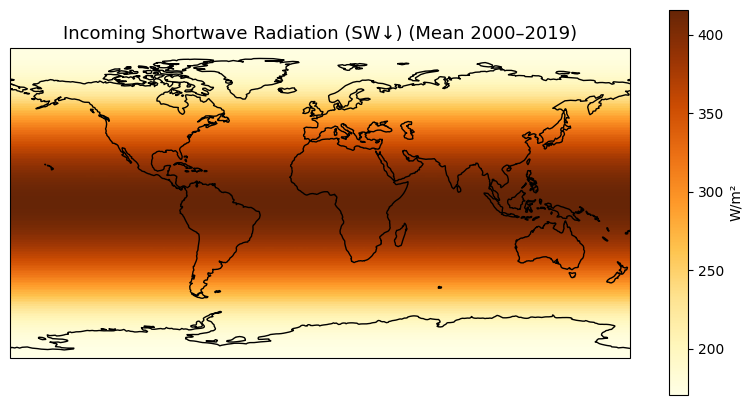

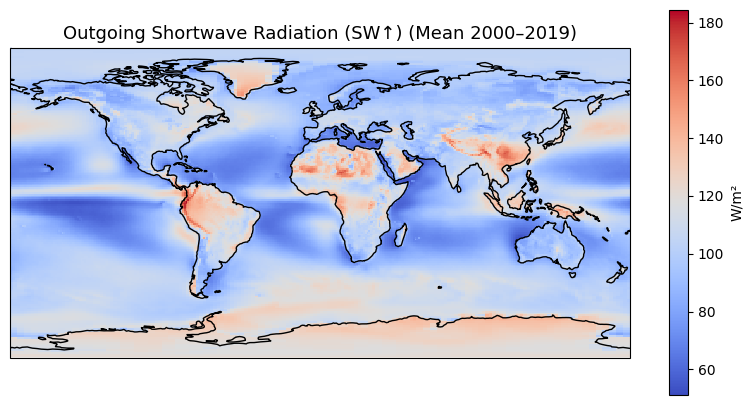

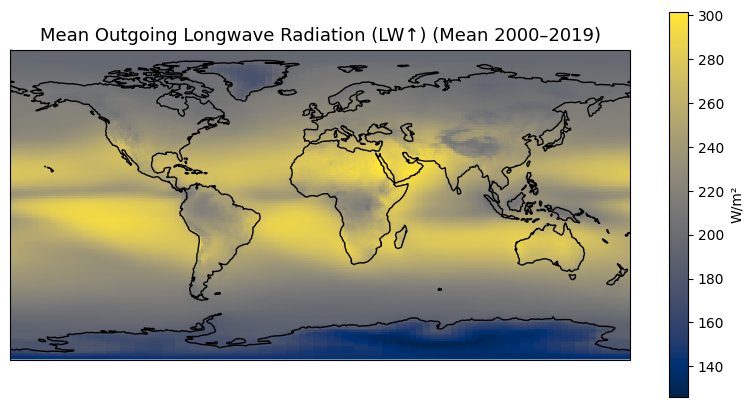

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import glob
import os

# === 1. Load dataset ===
# Path folder where the extracted files are located
extracted_folder = "/content/radiation_data"

# Find all .nc files in the extracted folder
all_files = glob.glob(os.path.join(extracted_folder, "*.nc"))

# Group files by variable type (adjust based on actual filenames if necessary)
# Assuming filenames contain "solar_mon", "toa_sw_all_mon", "toa_lw_all_mon"
files_incoming_sw = [f for f in all_files if "solar_mon" in f]
files_outgoing_sw = [f for f in all_files if "toa_sw_all_mon" in f]
files_outgoing_lw = [f for f in all_files if "toa_lw_all_mon" in f]

print("📂 Number of files per variable found after extraction:")
print("Incoming SW :", len(files_incoming_sw))
print("Outgoing SW :", len(files_outgoing_sw))
print("Outgoing LW :", len(files_outgoing_lw))


# Open datasets using open_mfdataset
ds_in_sw = xr.open_mfdataset(files_incoming_sw, combine='by_coords')
ds_out_sw = xr.open_mfdataset(files_outgoing_sw, combine='by_coords')
ds_out_lw = xr.open_mfdataset(files_outgoing_lw, combine='by_coords')


# === 2. Ambil nama variabel otomatis ===
def get_var(ds):
    # Assuming the main variable is the first one in data_vars
    for var in ds.data_vars:
        return var

var_in_sw = get_var(ds_in_sw)
var_out_sw = get_var(ds_out_sw)
var_out_lw = get_var(ds_out_lw)

# === 3. Ambil data per variabel ===
data_in = ds_in_sw[var_in_sw]
data_out_sw = ds_out_sw[var_out_sw]
data_out_lw = ds_out_lw[var_out_lw]

# === Select the desired time period (2000-2019) ===
data_in = data_in.sel(time=slice("2000-01-01", "2019-12-31"))
data_out_sw = data_out_sw.sel(time=slice("2000-01-01", "2019-12-31"))
data_out_lw = data_out_lw.sel(time=slice("2000-01-01", "2019-12-31"))


# === 4. Hitung rata-rata tahunan per grid ===
data_in_yr = data_in.groupby("time.year").mean("time")
data_out_sw_yr = data_out_sw.groupby("time.year").mean("time")
data_out_lw_yr = data_out_lw.groupby("time.year").mean("time")

# === 5. Buat pembobotan luas grid berdasarkan cos(latitude) ===
weights = np.cos(np.deg2rad(data_in_yr.lat))
weights.name = "weights"

# Fungsi untuk hitung global weighted mean
def weighted_mean_global(data, weights):
    # broadcasting weights ke dimensi lat, lon
    w = weights / weights.mean()  # normalisasi agar totalnya tidak terlalu besar
    return (data * w).mean(dim=["lat", "lon"], skipna=True)

# === 6. Hitung global mean terboboti untuk tiap variabel ===
mean_in = weighted_mean_global(data_in_yr, weights)
mean_out_sw = weighted_mean_global(data_out_sw_yr, weights)
mean_out_lw = weighted_mean_global(data_out_lw_yr, weights)

# === 7. Fungsi plot peta rata-rata tahunan (selama 2000–2025) ===
def plot_spatial_mean(data, title, cmap='inferno'):
    avg = data.mean(dim="year")
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = avg.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        cbar_kwargs={'label': 'W/m²'}
    )
    ax.coastlines()
    ax.set_title(title + " (Mean 2000–2019)", fontsize=13)
    ax.set_global()
    plt.show()

# === 8. Plot peta rata-rata spasial ===
plot_spatial_mean(data_in_yr, "Incoming Shortwave Radiation (SW↓)", cmap='YlOrBr')
plot_spatial_mean(data_out_sw_yr, "Outgoing Shortwave Radiation (SW↑)", cmap='coolwarm')
plot_spatial_mean(data_out_lw_yr, "Mean Outgoing Longwave Radiation (LW↑)", cmap='cividis')

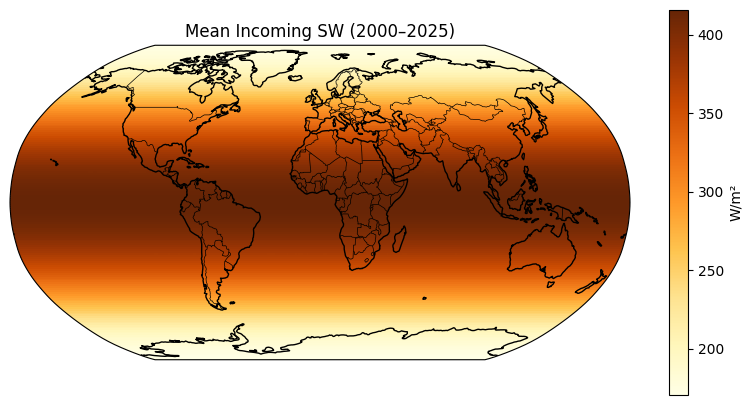

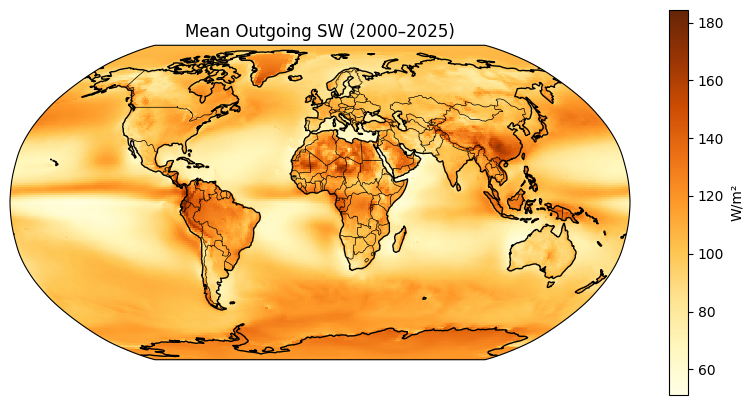

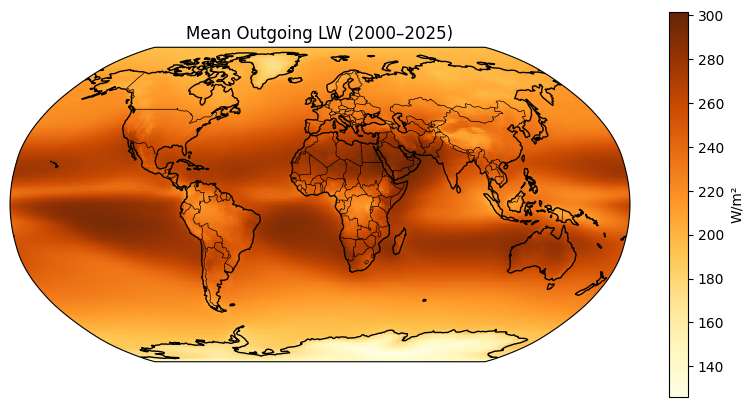

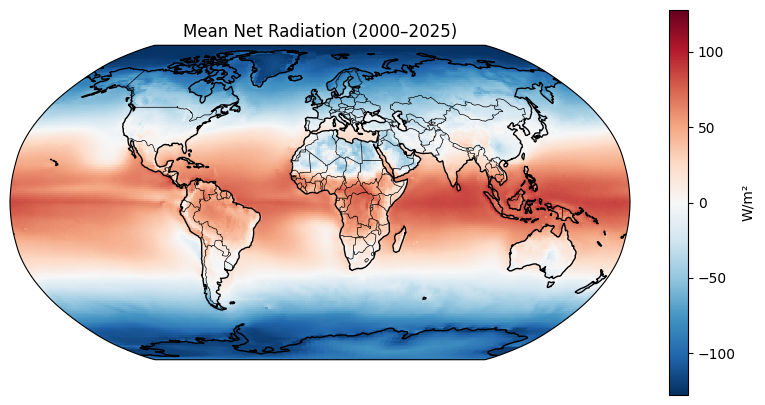

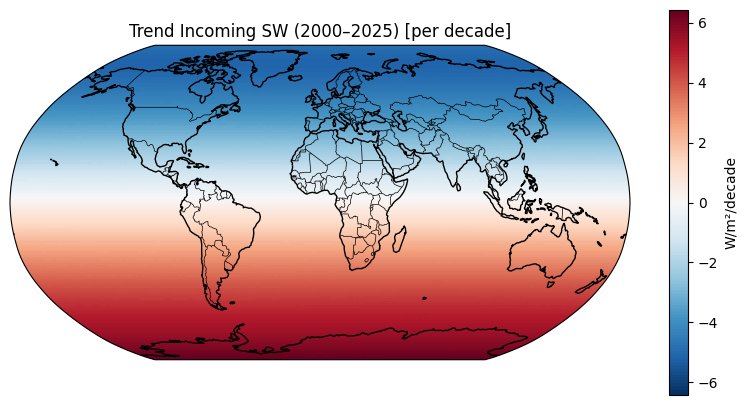

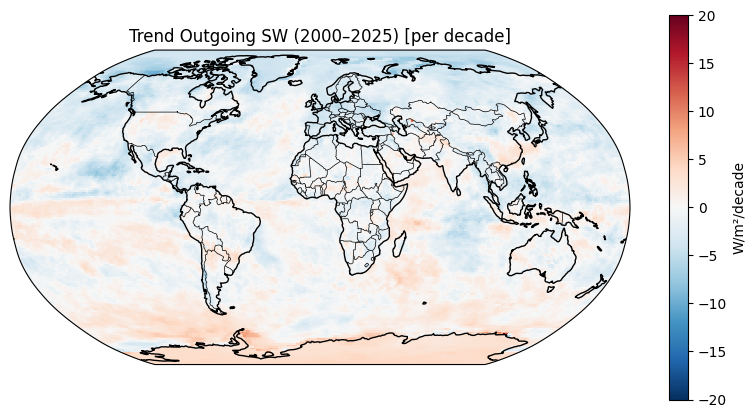

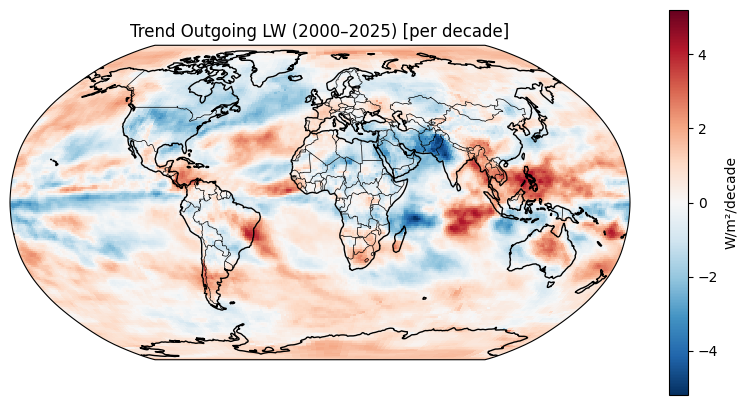

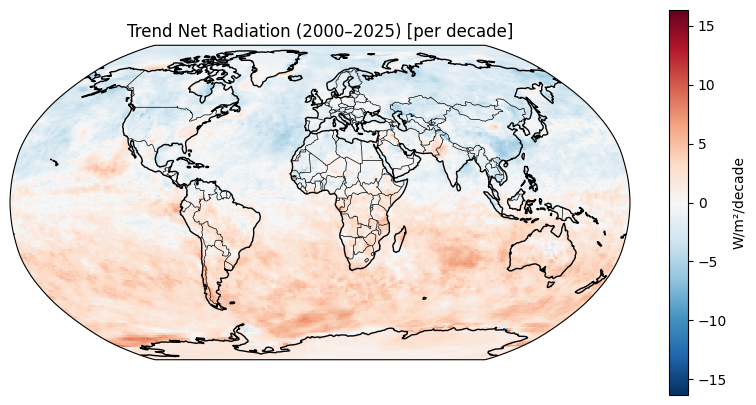

In [ ]:
warnings.filterwarnings("ignore")

# === 1. Load dataset ===
# Data is already loaded in previous cells as data_in, data_out_sw, data_out_lw

# === 2. Hitung Net Radiation ===
# Net = SW_in - (SW_out + LW_out)
# Renamed variables for clarity
net_radiation = data_in - data_out_sw - data_out_lw
net_radiation.name = "net_radiation"

# === 3. Pembobotan area (cos latitude) ===
# Renamed variable for clarity
area_weights = np.cos(np.deg2rad(data_in.lat))
area_weights.name = "area_weights"

# === 4. Hitung rata-rata tahunan ===
def calculate_yearly_mean(da):
    """Calculates the yearly mean for a DataArray."""
    return da.groupby("time.year").mean("time")

# Renamed variables for clarity
incoming_sw_yearly = calculate_yearly_mean(data_in)
outgoing_sw_yearly = calculate_yearly_mean(data_out_sw)
outgoing_lw_yearly = calculate_yearly_mean(data_out_lw)
net_radiation_yearly = calculate_yearly_mean(net_radiation)

# === 5. Hitung tren spasial (per grid) using xarray.polyfit ===
# Renamed variables for clarity
incoming_sw_trend_coeffs = incoming_sw_yearly.polyfit(dim='year', deg=1)
outgoing_sw_trend_coeffs = outgoing_sw_yearly.polyfit(dim='year', deg=1)
outgoing_lw_trend_coeffs = outgoing_lw_yearly.polyfit(dim='year', deg=1)
net_radiation_trend_coeffs = net_radiation_yearly.polyfit(dim='year', deg=1)


# Extract the slope (the first coefficient) and rename variables
incoming_sw_trend = incoming_sw_trend_coeffs['polyfit_coefficients'].isel(degree=0)
incoming_sw_trend.name = "Incoming SW Trend"

outgoing_sw_trend = outgoing_sw_trend_coeffs['polyfit_coefficients'].isel(degree=0)
outgoing_sw_trend.name = "Outgoing SW Trend"

outgoing_lw_trend = outgoing_lw_trend_coeffs['polyfit_coefficients'].isel(degree=0)
outgoing_lw_trend.name = "Outgoing LW Trend"

net_radiation_trend = net_radiation_trend_coeffs['polyfit_coefficients'].isel(degree=0)
net_radiation_trend.name = "Net Radiation Trend"


# Add units to the trend data arrays (polyfit doesn't automatically propagate units well for coefficients)
incoming_sw_trend.attrs["units"] = incoming_sw_yearly.attrs.get("units", "") + " / year"
outgoing_sw_trend.attrs["units"] = outgoing_sw_yearly.attrs.get("units", "") + " / year"
outgoing_lw_trend.attrs["units"] = outgoing_lw_yearly.attrs.get("units", "") + " / year"
net_radiation_trend.attrs["units"] = net_radiation_yearly.attrs.get("units", "") + " / year"


# === 6. Fungsi plot spasial ===
def plot_spatial(data, title, cmap="coolwarm", vmin=None, vmax=None, cbar_label=None):
    """Plots a spatial DataArray."""
    plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.Robinson())
    im = data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        cbar_kwargs={"label": cbar_label if cbar_label else data.name},
        vmin=vmin,
        vmax=vmax,
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(title, fontsize=12)
    plt.show()

# === 7. Plot rata-rata tahunan (climatology 2000–2025) ===
plot_spatial(incoming_sw_yearly.mean("year"), "Mean Incoming SW (2000–2025)", cmap="YlOrBr", cbar_label='W/m²')
plot_spatial(outgoing_sw_yearly.mean("year"), "Mean Outgoing SW (2000–2025)", cmap="YlOrBr", cbar_label='W/m²')
plot_spatial(outgoing_lw_yearly.mean("year"), "Mean Outgoing LW (2000–2025)", cmap="YlOrBr", cbar_label='W/m²')
plot_spatial(net_radiation_yearly.mean("year"), "Mean Net Radiation (2000–2025)", cmap="RdBu_r", cbar_label='W/m²')

# === 8. Plot tren spasial ===
plot_spatial(incoming_sw_trend * 10, "Trend Incoming SW (2000–2025) [per decade]", cmap="RdBu_r", cbar_label='W/m²/decade')
plot_spatial(outgoing_sw_trend * 10, "Trend Outgoing SW (2000–2025) [per decade]", cmap="RdBu_r", cbar_label='W/m²/decade')
plot_spatial(outgoing_lw_trend * 10, "Trend Outgoing LW (2000–2025) [per decade]", cmap="RdBu_r", cbar_label='W/m²/decade')
plot_spatial(net_radiation_trend * 10, "Trend Net Radiation (2000–2025) [per decade]", cmap="RdBu_r", cbar_label='W/m²/decade')

#AOD 2000-2025

In [ ]:
# === 1. Install dependencies ===
!pip install requests netrc4

# === 2. Setup Earthdata credentials ===
import os
from getpass import getpass

# Masukkan username dan password Earthdata (buat cookie wget)
username = input("Masukkan username Earthdata: ")
password = getpass("Masukkan password Earthdata: ")

# Simpan kredensial ke file .netrc
with open(os.path.expanduser("~/.netrc"), "w") as f:
    f.write(f"machine urs.earthdata.nasa.gov login {username} password {password}\n")
os.chmod(os.path.expanduser("~/.netrc"), 0o600)

print("✅ Login Earthdata selesai! Siap download MERRA-2.")

ERROR: Could not find a version that satisfies the requirement netrc4 (from versions: none)
ERROR: No matching distribution found for netrc4
Masukkan username Earthdata: dannacarln
Masukkan password Earthdata: ··········
✅ Login Earthdata selesai! Siap download MERRA-2.


In [ ]:
import subprocess

# === 1. Set parameter dataset ===
base_url = "https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2_MONTHLY/M2IMNXGAS.5.12.4"
save_dir = "/content/merra2_downloads"
os.makedirs(save_dir, exist_ok=True)

# === 2. Loop untuk setiap tahun dan bulan ===
for year in range(2020, 2026):  # 2020–2025
    for month in range(1, 13):
        if (year == 2025 and month > 10):  # stop di Okt 2025
            break

        # Tentukan kode batch (300–400 tergantung tahun)
        if year <= 1991:
            batch = "100"
        elif year <= 2000:
            batch = "200"
        elif year <= 2010:
            batch = "300"
        else:
            batch = "400"

        # Format nama file
        fname = f"MERRA2_{batch}.instM_2d_gas_Nx.{year}{month:02d}.nc4"
        url = f"{base_url}/{year}/{fname}"
        fpath = os.path.join(save_dir, fname)

        # Skip kalau sudah ada
        if os.path.exists(fpath):
            print(f"✅ {fname} sudah ada, skip...")
            continue

        # Download file dengan wget + cookie Earthdata
        print(f"⬇️ Mengunduh {fname} ...")
        cmd = [
            "wget", "--load-cookies", "~/.urs_cookies",
            "--save-cookies", "~/.urs_cookies",
            "--auth-no-challenge=on", "--keep-session-cookies",
            "--content-disposition", url, "-P", save_dir
        ]
        subprocess.run(cmd)

⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202001.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202002.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202003.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202004.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202005.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202006.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202007.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202008.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202009.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202010.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202011.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202012.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202101.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202102.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202103.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202104.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202105.nc4 ...
⬇️ Mengunduh MERRA2_400.instM_2d_gas_Nx.202106.nc4 ...
⬇️ Mengund

In [ ]:
#test 1 sample
import xarray as xr
import glob

# Ambil satu contoh file
file_example = sorted(glob.glob(f"{save_dir}/*.nc4"))[0]
ds = xr.open_dataset(file_example)
ds

<xarray.Dataset> Size: 3MB
Dimensions:     (time: 1, lat: 361, lon: 576)
Coordinates:
  * time        (time) datetime64[ns] 8B 2020-01-01
  * lat         (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon         (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
Data variables:
    AODANA      (time, lat, lon) float32 832kB ...
    AODINC      (time, lat, lon) float32 832kB ...
    Var_AODANA  (time, lat, lon) float32 832kB ...
    Var_AODINC  (time, lat, lon) float32 832kB ...
Attributes: (12/30)
    Contact:                           http://gmao.gsfc.nasa.gov
    History:                           Original file generated: Tue Feb 11 22...
    Filename:                          MERRA2_400.instM_2d_gas_Nx.202001.nc4
    Comment:                           GMAO filename: d5124_m2_jan10.inst3_2d...
    Source:                            CVS tag: GEOSadas-5_12_4_p23_sp3_M2-OP...
    Conventions:                       CF-1
    ...                                ...
    LatitudeResolution:                0.5
    LongitudeResolution:               0.625
    DataResolution:                    0.5 x 0.625
    identifier_product_doi:            10.5067/XOGNBQEPLUC5
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   21:00:00.000000

Jumlah file bulanan total: 302 (2000–2025)
 - MERRA2_200.instM_2d_gas_Nx.200001.nc4
 - MERRA2_200.instM_2d_gas_Nx.200002.nc4
 - MERRA2_200.instM_2d_gas_Nx.200003.nc4
 - MERRA2_200.instM_2d_gas_Nx.200004.nc4
 - MERRA2_200.instM_2d_gas_Nx.200005.nc4
Data bulanan shape: (302, 361, 576)
Data tahunan shape: (26,)
✅ Saved: trend_merra2_annual_2000_2025.nc


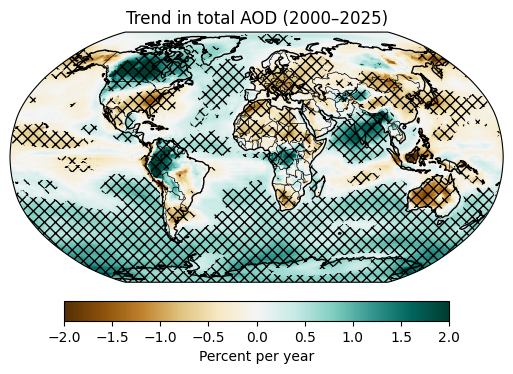

In [ ]:
warnings.filterwarnings("ignore")

path_1 = "/content/drive/MyDrive/Data_Periklim/AOD"         # data 2000–2019
path_2 = "/content/merra2_downloads"                         # data 2020–2025

# Gabungkan daftar semua file .nc4
file_list = sorted([
    os.path.join(p, f)
    for p in [path_1, path_2]
    for f in os.listdir(p)
    if f.endswith(".nc4")
])

print(f"Jumlah file bulanan total: {len(file_list)} (2000–2025)")
for f in file_list[:5]:
    print(" -", os.path.basename(f))

if len(file_list) == 0:
    raise FileNotFoundError("Tidak menemukan file .nc4 di kedua folder")

# -------------------------
# 1) Baca semua file bulanan dan ekstrak variabel AOD
# -------------------------
aod_total_list = []
aod_fine_list = []
time_list = []

for f in file_list:
    ds = xr.open_dataset(f)

    # variabel AOD total dan fine-mode
    if "TOTEXTTAU" in ds.data_vars:
        aod_total = ds["TOTEXTTAU"]
    elif "AODANA" in ds.data_vars:
        aod_total = ds["AODANA"]
    else:
        raise KeyError(f"Tidak menemukan variabel total AOD di {f}")

    if "TOTSCATAU" in ds.data_vars:
        aod_fine = ds["TOTSCATAU"]
    else:
        aod_fine = aod_total * np.nan  # placeholder nan jika tidak ada fine-mode

    # ambil waktu dari nama file (misal: MERRA2_400.tavgM_2d_aer_Nx.202010.nc4)
    basename = os.path.basename(f)
    ym = basename.split(".")[-2]
    year, month = int(ym[:4]), int(ym[4:6])
    time = np.datetime64(f"{year}-{month:02d}-01")

    aod_total_list.append(aod_total.squeeze())
    aod_fine_list.append(aod_fine.squeeze())
    time_list.append(time)

# satukan jadi satu DataArray
da_total = xr.concat(aod_total_list, dim="time")
da_fine  = xr.concat(aod_fine_list,  dim="time")
da_total["time"] = time_list
da_fine["time"]  = time_list

print("Data bulanan shape:", da_total.shape)

# 2) Rata-rata tahunan (dengan pembobotan cos(lat))

weights = np.cos(np.deg2rad(da_total.lat))
weights.name = "weights"

# Group by year first, then apply weighted mean
da_total_yearly = da_total.groupby("time.year").mean().weighted(weights).mean(("lat", "lon"))
da_fine_yearly  = da_fine.groupby("time.year").mean().weighted(weights).mean(("lat", "lon"))


print("Data tahunan shape:", da_total_yearly.shape)

# 3) Hitung trend (2000–2025)

lat = da_total.lat
lon = da_total.lon
ny, nx = len(lat), len(lon)

def calc_trend(data):
    trend = np.full((ny, nx), np.nan)
    sig = np.zeros((ny, nx))
    for j in range(ny):
        for i in range(nx):
            y = data[:, j, i].values
            valid = np.isfinite(y) & (y > 0)
            n = valid.sum()
            if n > 5:
                x = np.arange(n)
                yv = y[valid]
                slope, intercept, r_val, pval, stderr = linregress(x, yv)
                m = np.nanmean(yv)
                trend[j, i] = (slope / m) * 100 if m != 0 else np.nan
                sig[j, i] = 0.1 if pval < 0.1 else 0.0
    return trend, sig

# Corrected: Calculate yearly mean per grid cell
da_total_yearly_spatial = da_total.groupby("time.year").mean("time")
da_fine_yearly_spatial  = da_fine.groupby("time.year").mean("time")

# Now calculate spatial trend using the yearly spatial data
trend_total, sig_total = calc_trend(da_total_yearly_spatial)
trend_fine, sig_fine   = calc_trend(da_fine_yearly_spatial)


# 4) Simpan hasil ke NetCDF
ds_out = xr.Dataset(
    {
        "trend_total": (("lat","lon"), trend_total),
        "sig_total": (("lat","lon"), sig_total),
        "trend_fine": (("lat","lon"), trend_fine),
        "sig_fine": (("lat","lon"), sig_fine),
    },
    coords={"lat": lat, "lon": lon}
)
out_nc = "trend_merra2_annual_2000_2025.nc"
ds_out.to_netcdf(out_nc)
print("✅ Saved:", out_nc)


fig = plt.figure(figsize=(14,5))
vmin, vmax = -2.0, 2.0

ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
ax1.set_global()
im1 = ax1.pcolormesh(lon, lat, trend_total, transform=ccrs.PlateCarree(),
                     cmap="BrBG", vmin=vmin, vmax=vmax)
ax1.coastlines(); ax1.add_feature(cfeature.BORDERS, linewidth=0.5)
ax1.set_title("Trend in AOD (2000–2025)")

mask_ns = np.isnan(sig_total) | (sig_total == 0)
lon2d, lat2d = np.meshgrid(lon, lat)
ax1.contourf(lon2d, lat2d, mask_ns, levels=[-0.5,0.5,1.5],
             colors="none", hatches=['xxx',''], transform=ccrs.PlateCarree(), alpha=0)

cbar1 = fig.colorbar(im1, ax=ax1, orientation="horizontal", pad=0.05, fraction=0.05)
cbar1.set_label("Percent per year")